In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from adjoint_esn.utils.dynamical_systems import Lorenz63
import adjoint_esn.utils.solve_ode as solve_ode
from adjoint_esn.utils import preprocessing as pp
import adjoint_esn.utils.lyapunov as lyap
from adjoint_esn.esn import ESN
from adjoint_esn.validation import set_ESN
from adjoint_esn.utils import errors,scalers
from adjoint_esn.validation import validate
from adjoint_esn.validation import set_ESN

## Generate data

In [2]:
# run lorenz63 system
my_lorenz63 = Lorenz63(beta=8/3, rho=28, sigma=10, t_lyap=0.9**(-1))

dt = 0.01

transient_time = 20
washout_time = 1
train_time = 100
val_time = 10
test_time = 500

simulation_time = transient_time+3*washout_time+train_time+val_time+test_time

t = np.arange(0,simulation_time+dt,dt)
# u0 = np.array([ 7.432487609628195, 10.02071718705213, 29.62297428638419]) 
u0 = np.array([0.0, 1.0, 1.0]) 
u = solve_ode.integrate(my_lorenz63.ode, u0, t, integrator='rk4')

Running solver.


In [3]:
# separate into washout and loops
network_dt = dt
loop_times = [train_time,val_time,test_time]
loop_names = ['train','val','test']

u, t = pp.discard_transient(u, t, transient_time)

N_washout, *N_loops = [
    pp.get_steps(t, network_dt) for t in [washout_time, *loop_times]
]
start_idx = 0
data = {}
for loop_idx, N_loop in enumerate(N_loops):
    # get washout and loop data
    u_washout, u_loop, y_loop, t_loop = pp.create_input_output(
        u[start_idx:], u[start_idx:], t[start_idx:], N_washout, N_loop + 1
    )
    if loop_names is not None:
        loop_name = loop_names[loop_idx]
    else:
        loop_name = f"loop_{loop_idx}"

    data[loop_name] = {
        "u_washout": u_washout,
        "u": u_loop,
        "y": y_loop,
        "t": t_loop,
    }
    start_idx += N_washout + N_loop

## Hyperparameter search

In [4]:
# hyperparameter names, should match the attributes of ESN
hyp_param_names = ['spectral_radius','input_scaling','tikhonov']

# range for hyperparameters 
spec_in     = 0.1
spec_end    = 1.0
in_scal_in  = 0.1
in_scal_end = 5.0
leak_in     = 0.1    
leak_end    = 1.0
tikh_in = 1e-12
tikh_end = 1e-6
grid_range = [[spec_in, spec_end],
              [in_scal_in, in_scal_end],
            #   [leak_in, leak_end],
              [tikh_in, tikh_end]]

# scales, uniform or log10
hyp_param_scales = ['uniform','log10','log10']

# scale the ranges
for i in range(len(grid_range)):
    for j in range(2):
        scaler = getattr(scalers, hyp_param_scales[i])
        grid_range[i][j] = scaler(grid_range[i][j])

fold_time = 0.5*my_lorenz63.t_lyap
N_val = pp.get_steps(fold_time, network_dt)
N_val = 50
reservoir_size = 100
connectivity = 3
ESN_dict = {'reservoir_size': reservoir_size, 
            'dimension' : my_lorenz63.N_dim, 
            'reservoir_connectivity' : connectivity,
            'reservoir_weights_mode': "erdos_renyi1",
            'tikhonov': 1e-3,
            'input_bias' : np.array([1.0]),
            'output_bias' : np.array([1.0]),
            }
min_dict = validate(grid_range,hyp_param_names,hyp_param_scales,
    n_calls = 20, n_initial_points = 10,
    ESN_dict = ESN_dict, ESN_type = "standard",
    U_washout_train = data["train"]["u_washout"],
    U_train = data["train"]["u"],
    U_val = data["val"]["u"],
    Y_train = data["train"]["y"],
    Y_val = data["val"]["y"],
    n_folds=2,
    n_realisations=5,
    N_washout_steps = N_washout,
    N_val_steps = N_val,
    random_seed=20,
    n_grid = None)

--NEW RUN-- 1
Realisation: 0
spectral_radius 0.8986705348487375
input_scaling 4.18328857077979
tikhonov 1e-06


Val regime: 0
Fold: 0 , fold error:  21.802972404199245
Fold: 1 , fold error:  8.688647019061536
Val regime error: 15.24580971163039
Realisation error: 15.24580971163039


Realisation: 1
spectral_radius 0.8986705348487375
input_scaling 4.18328857077979
tikhonov 1e-06


Val regime: 0
Fold: 0 , fold error:  7.075129827841102
Fold: 1 , fold error:  12076.422352413218
Val regime error: 6041.748741120529
Realisation error: 6041.748741120529


Realisation: 2
spectral_radius 0.8986705348487375
input_scaling 4.18328857077979
tikhonov 1e-06


Val regime: 0
Fold: 0 , fold error:  8.362839245361059
Fold: 1 , fold error:  10.684753272711953
Val regime error: 9.523796259036505
Realisation error: 9.523796259036505


Realisation: 3
spectral_radius 0.8986705348487375
input_scaling 4.18328857077979
tikhonov 1e-06


Val regime: 0
Fold: 0 , fold error:  13.396005057370845
Fold: 1 , fold error: 

c:\Users\egeoz\anaconda3\envs\esn_env\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.57961e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  34696.24549961614
Fold: 1 , fold error:  15843.91898393734
Val regime error: 25270.08224177674
Realisation error: 25270.08224177674


Realisation: 2
spectral_radius 0.5296489325560247
input_scaling 2.9624550156592733
tikhonov 1e-10




c:\Users\egeoz\anaconda3\envs\esn_env\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.14998e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  10.325546019554423
Fold: 1 , fold error:  3.041701556318391
Val regime error: 6.683623787936407
Realisation error: 6.683623787936407


Realisation: 3
spectral_radius 0.5296489325560247
input_scaling 2.9624550156592733
tikhonov 1e-10




c:\Users\egeoz\anaconda3\envs\esn_env\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.35171e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  205660.14221511397
Fold: 1 , fold error:  150150.52898347666
Val regime error: 177905.33559929533
Realisation error: 177905.33559929533


Realisation: 4
spectral_radius 0.5296489325560247
input_scaling 2.9624550156592733
tikhonov 1e-10




c:\Users\egeoz\anaconda3\envs\esn_env\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.63407e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  10.667263144484426
Fold: 1 , fold error:  11.809844154549097
Val regime error: 11.238553649516762
Realisation error: 11.238553649516762


Run 5 error: 50789.88770475776


--NEW RUN-- 6
Realisation: 0
spectral_radius 0.9158805549519091
input_scaling 0.10053776822301841
tikhonov 1e-09


Val regime: 0
Fold: 0 , fold error:  0.009566673397368613
Fold: 1 , fold error:  0.009632495068054166
Val regime error: 0.00959958423271139
Realisation error: 0.00959958423271139


Realisation: 1
spectral_radius 0.9158805549519091
input_scaling 0.10053776822301841
tikhonov 1e-09


Val regime: 0
Fold: 0 , fold error:  0.0025920021314233322
Fold: 1 , fold error:  0.002521071729031338
Val regime error: 0.002556536930227335
Realisation error: 0.002556536930227335


Realisation: 2
spectral_radius 0.9158805549519091
input_scaling 0.10053776822301841
tikhonov 1e-09


Val regime: 0
Fold: 0 , fold error:  0.030999633324457355
Fold: 1 , fold error:  0.0999102301090763
Val regime

## Train 

In [5]:
res_idx = 0
my_ESN = ESN(**ESN_dict)
hyp_params = [min_dict[hyp_param_name][res_idx] for hyp_param_name in hyp_param_names]
hyp_param_scales = ['uniform']*len(hyp_param_names)
set_ESN(my_ESN,hyp_param_names,hyp_param_scales,hyp_params)

my_ESN.train(data["train"]["u_washout"], data["train"]["u"], data["train"]["y"])

Input normalization is changed, training must be done again.
Parameter normalization is changed, training must be done again.
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Spectral radius is set to 1, set it separately if necessary.
Reservoir weights are rescaled with the new spectral radius.
Reservoir weights are rescaled with the new spectral radius.
Input weights are rescaled with the new input scaling.


## Predict and visualize

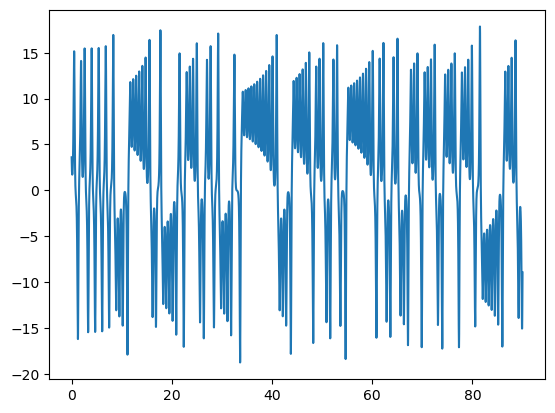

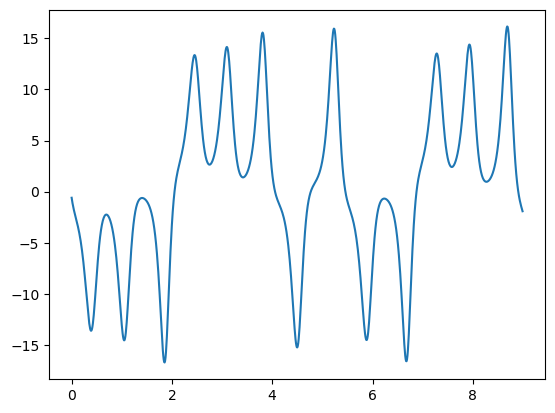

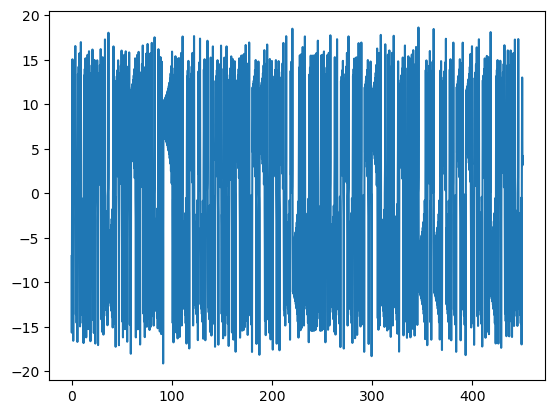

In [7]:
pred = {}
for loop_name in loop_names:
    pred[loop_name] = {}
    pred[loop_name]["X"], pred[loop_name]["y"] = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"],
                                                    N_t=len(data[loop_name]["u"]),)
    plt.figure()
    plt.plot((data[loop_name]["t"]-data[loop_name]["t"][0])/my_lorenz63.t_lyap,data[loop_name]["y"][:,0])
    plt.plot((data[loop_name]["t"]-data[loop_name]["t"][0])/my_lorenz63.t_lyap,pred[loop_name]["y"][1:,0],'--')


## Lyapunov stability analysis

In [45]:
LEs, FTLE, QQ, RR = lyap.calculate_LEs(sys=my_lorenz63,
                                 sys_type='continuous',
                                 X=data["test"]["u"],
                                 t=data["test"]["t"],
                                 transient_time=transient_time,
                                 dt=dt,
                                 target_dim=None,
                                 norm_step=1)
LEs_target = LEs[-1]
print(LEs_target)
CLVs, angles, FTCLE = lyap.calculate_CLVs(QQ,RR,dt)

[ 9.00508937e-01 -2.07512880e-03 -1.45649987e+01]


In [46]:
LEs, FTLE, QQ, RR = lyap.calculate_LEs(sys=my_ESN,
                                 sys_type='ESN',
                                 X=pred["test"]["X"],
                                 t=data["test"]["t"],
                                 transient_time=transient_time,
                                 dt=dt,
                                 target_dim=my_lorenz63.N_dim,
                                 norm_step=1)
LEs_target = LEs[-1]
print(LEs_target)
CLVs, angles, FTCLE = lyap.calculate_CLVs(QQ,RR,dt)

[ 9.08731955e-01 -1.80437125e-03 -1.72292874e+01]
